# Evaluating AI sourcing tools

## Using proprietary scoring method

In [168]:
%cd ~/ai-sourcing-benchmark/

/home/vslaykovsky/ai-sourcing-benchmark


In [169]:
import pandas as pd
pd.set_option('display.max_columns', 100)
DROP_PROFILES = False

In [170]:
import glob
import os


def load_search_results():
    out = []
    for f in glob.glob('data/search_results/*.csv'):
        df = pd.read_csv(f)
        df['source'] = {'exa.csv': 'Exa.AI', 'pearch.csv': 'Pearch.AI', 'people.csv': 'PeopleGPT', 'link.csv': 'LinkedIn'}[os.path.basename(f)]
        out.append(df)
    df = pd.concat(out)
    if DROP_PROFILES:
        df.drop(columns=['profile'], errors='ignore', inplace=True)
    return df

df_sr = load_search_results()
df_sr.head(2)

,query_id,query,search_rank,docid,reranking_group,source
0,49181,I'm looking for a VP or Head of Sales for a he...,0,nick-talone,2.0,PeopleGPT
1,49181,I'm looking for a VP or Head of Sales for a he...,1,jason-de-turris-4b56a933,1.0,PeopleGPT


In [171]:
df_sr.sample(frac=1., random_state=42)['query'].drop_duplicates().head(5).tolist()

['A backend engineer from a top computer science program living in san francisco with 5 years experience working in startups developing performant and scalable backend systems and databases',
 'founders who sold their companies or did an IPO. Only show people from the U.S.',
 'Customer success managers with at least 3 years of experience who are located in the San Francisco Bay Area. I would like them to come from companies that are Series A, Series B, or Series C. They need to have worked in healthcare technology at a SAAS company',
 'engineers with security clearance from top engineering programs. Only show people from the U.S.',
 'looking for a CTO with experience in AI and machine learning, who has also led a team of 50+ developers. Bonus if they have a background in cybersecurity. Only show people from the U.S.']

In [172]:
overal_stats = df_sr.groupby('source').agg(Queries=('query', lambda v: v.nunique()), TotalResults=('query', len), AveragePerQuery=('query', lambda g: g.value_counts().mean().round(1)))
overal_stats

,Queries,TotalResults,AveragePerQuery
source,,,
Exa.AI,48,465,9.7
LinkedIn,48,465,9.7
Pearch.AI,45,398,8.8
PeopleGPT,42,407,9.7


# Side by side comparison with LLM prompt and Human experts

In [173]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

In [174]:
def generate_sbs_samples(df, limit):
    df = df.sample(frac=1.0, random_state=42)
    groups = list(df.groupby(['query', 'search_rank']))
    results = []
    for (q, r), g in groups:
        for i in range(len(g) - 1):
            results.append([q, r] + g.iloc[i].filter(['source', 'docid', 'profile']).tolist() + g.iloc[i+1].filter(['source', 'docid', 'profile']).tolist())
    if 'profile' in df.columns:
        cols = ['query', 'rank', 'source1', 'docid1', 'profile1', 'source2', 'docid2', 'profile2']            
    else:
        cols = ['query', 'rank', 'source1', 'docid1', 'source2', 'docid2']            
    return pd.DataFrame(columns=cols, data=results).sample(frac=1.0, random_state=42).query('source1 != source2').head(limit)


df_sbs = generate_sbs_samples(df_sr, limit=1000)
df_sbs.head(4).reset_index(drop=True)


,query,rank,source1,docid1,source2,docid2
0,"python developer, russian speaking, 7+ years o...",6,PeopleGPT,vegasq,Exa.AI,ana7pana
1,AI strategy consultant with a technical backgr...,4,Exa.AI,anakraftai,LinkedIn,kevinlyonsnyc
2,A backend engineer from a top computer science...,7,PeopleGPT,oleg-petrunya-034a4b1,Pearch.AI,stevenschlansker
3,A perception or computer vision engineer with ...,1,LinkedIn,jayant1408,PeopleGPT,nghia-ho-6259866


In [175]:
from openai import OpenAI

def openrouter(prompt, model="openai/o3-mini"):
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=os.environ.get("OPENROUTER_API_KEY"),
    )
    completion = client.chat.completions.create(
    model=model,
    messages=[
        {
        "role": "user",
        "content": prompt
        }
    ]
    )
    return completion.choices[0].message.content



In [176]:
import json
import re
import time

def parse_3backticks(answer: str, as_list: bool = False):
    v = re.findall(r"`{3,}\w*((?:(?!```).){2,})`{3,}", answer, re.DOTALL)
    if as_list:
        if len(v) == 0:
            return [answer]
        else:
            return v
    else:
        if len(v) == 0:
            return answer
        else:
            return v[-1]
        
def parse_json(answer):
    data = parse_3backticks(answer, as_list=False)
    return json.loads(data)

def process_row(r):
    for i in range(3):
        try:
            query = r['query']
            prompt = f"""I'll give you a search query for a working professional and two candidate profiles. Your task is to decide which profile is the better match.  
Make sure to consider all specific requirements in the query. Also, check if a candidate is overqualified or underqualified.
Output your decision as JSON: {{
'profile_idx': int # 1 or 2
'summary': str # very short summary explaining the decision
}}

Search query: {query}


Profile 1: {r.profile1}

Profile 2: {r.profile2}"""
            v = openrouter(prompt)
            v = parse_json(v)
            profile_idx = v['profile_idx']        
            return (r.get('source1', 'A') if profile_idx == 1 else r.get('source2', 'B')), v['summary']
        except Exception as ex:
            print(ex)
            time.sleep(1)


def run_llm_sbs(df_sbs, cache_file):
    df_cachehit = pd.DataFrame()
    df_cachemiss = df_sbs
    if os.path.exists(cache_file):
        cache = pd.read_csv(cache_file)
        cache = cache.drop_duplicates(subset=['query', 'docid1', 'docid2']).set_index(['query', 'docid1', 'docid2'])[['LLM winner', 'LLM summary']]
        df_sbs = df_sbs.set_index(['query', 'docid1', 'docid2']).join(cache, how='left').reset_index()

        df_cachemiss = df_sbs[df_sbs['LLM winner'].isna()].copy()
        df_cachehit = df_sbs[~df_sbs['LLM winner'].isna()].copy()
        print('cache miss', len(df_cachemiss), 'cache hit', len(df_cachehit))

    if not df_cachemiss.empty:
        results = []
        with ThreadPoolExecutor(20) as executor:
            futures = [executor.submit(process_row, r) for _, r in df_cachemiss.iterrows()]
            for future in tqdm(futures, total=len(futures), desc="Processing rows"):
                results.append(future.result())
        df_cachemiss['LLM winner'] = [v[0] if v else None for v in results]
        df_cachemiss['LLM summary'] = [v[1] if v else None for v in results]

    df_sbs = pd.concat([df_cachehit, df_cachemiss])
    df_sbs.to_csv(cache_file, index=False)    
    return df_sbs


In [177]:
from elosports.elo import Elo

def sbs_elo(df_sbs, n_samples=100, bootstrap=False, winner_col='LLM winner'):
    results = []
    for smpl in tqdm(range(n_samples), 'Elo samples'):
        eloLeague = Elo(k=20, homefield=False)
        if bootstrap:
            sample_df = df_sbs.sample(n=len(df_sbs), replace=True)
        else:
            sample_df = df_sbs.sample(frac=1.0)
        for player in set(sample_df.source1.unique().tolist() + sample_df.source2.unique().tolist()):
            eloLeague.addPlayer(player)
        for id, r in sample_df.iterrows():
            if r.source1 == r.source2:
                continue
            players = set(r[['source1', 'source2']].tolist())
            
            loser = list(players - set([r[winner_col]]))
            if not loser:
                print(players, r[winner_col], loser, id, r)
            loser = loser[0]
            eloLeague.gameOver(winner=r[winner_col], loser=loser, winnerHome=False)
        results.append(eloLeague.ratingDict)    
    df = pd.DataFrame(results)
    df_mean = df.mean().sort_values()
    df = df[df_mean.index]
    return df

## Human labels

In [178]:

from concurrent.futures import ThreadPoolExecutor
import numpy as np
from tqdm import tqdm


def to_url(docid):
    return f'https://linkedin.com/in/{docid}'


HUMAN_TASKS_DIR = 'data/human_tasks'
GENERATE_HUMAN_TASKS = False
if GENERATE_HUMAN_TASKS:    
    !mkdir -p $HUMAN_TASKS_DIR/anonymized
    !mkdir -p $HUMAN_TASKS_DIR/keys
    df_sbs = generate_sbs_samples(df_sr, limit=1000)
    for idx, g in enumerate(np.array_split(df_sbs.sample(frac=1.0, random_state=42), 10)):
        g['url1'] = g.docid1.apply(to_url)
        g['url2'] = g.docid2.apply(to_url)
        g['winner'] = ''
        g['comment'] = ''
        g[['query', 'url1', 'url2', 'winner', 'comment']].sort_values('query').to_csv(f'{HUMAN_TASKS_DIR}/anonymized/batch_{idx:03d}.csv')
        g.sort_values('query')['query,rank,source1,docid1,source2,docid2,url1,url2,winner,comment'.split(',')].to_csv(f'{HUMAN_TASKS_DIR}/keys/batch_{idx:03d}.csv')        

In [179]:
import pandas as pd
import glob
from tqdm import tqdm 
import re

def extract_info_from_filename(filename):
    pattern = r'data/human_labels/(?P<recruiter>Recruiter[^_]*)_Batch(?P<batch>\d+)(?P<test>_Test)?\.csv'
    match = re.match(pattern, filename)
    if match:
        return match.group('recruiter'), match.group('batch'), match.group('test') is not None
    return None, None, False

def read_human_labels():
    dfs = []
    for f in tqdm(glob.glob('data/human_labels/*.csv'), desc="Reading CSV files"):
        recruiter, batch, is_test = extract_info_from_filename(f)
        df = pd.read_csv(f).fillna('').astype(str)
        df['worker'] = recruiter
        df['batch'] = batch
        df['is_test'] = is_test
        df['docid1'] = df['Candidate A'].apply(lambda v: v.split('/')[-1])
        df['docid2'] = df['Candidate B'].apply(lambda v: v.split('/')[-1])        
        dfs.append(df)    

    df = pd.concat(dfs)
    if 'profile' in df_sr.columns:
        df = df.set_index('docid1').join(df_sr.set_index('docid')[['profile']].drop_duplicates(), how='left').reset_index().rename(columns={'profile': 'profile1'})
        df = df.set_index('docid2').join(df_sr.set_index('docid')[['profile']].drop_duplicates(), how='left').reset_index().rename(columns={'profile': 'profile2'})    
    df.rename(columns={'Query': 'query', 'Winner': 'winner'}, inplace=True)
    df = df[df['winner'] != '']
    df['id'] = df['id'].astype(int)
    df_keys = pd.concat([pd.read_csv(f) for f in glob.glob(os.path.join(HUMAN_TASKS_DIR, 'keys/*.csv'))])
    df = df.set_index('id').join(df_keys.set_index('id')[['source1', 'source2']])
    df['Human winner'] = df.apply(lambda r: r.source1 if r.winner == 'A' else r.source2, axis=1)
    return df.drop(columns=['winner'])


df_human = read_human_labels()
print(len(df_human))
df_human.head(2)

Reading CSV files: 100%|██████████| 17/17 [00:00<00:00, 261.63it/s]

1257


,query,Candidate A,Candidate B,Comment,worker,batch,is_test,docid1,docid2,source1,source2,Human winner
id,,,,,,,,,,,,
739,A backend engineer from a top computer science...,https://linkedin.com/in/cameron-froehlich-84b8...,https://linkedin.com/in/hanifigunes,winner has more hardcore startup experience an...,Recruiter008,008,True,cameron-froehlich-84b86891,hanifigunes,Pearch.AI,PeopleGPT,Pearch.AI
727,A Boston University (BU) alum that is a head o...,https://linkedin.com/in/moraviameansquality,https://linkedin.com/in/eric-gross-oz,This was close- both fit the query- the winner...,Recruiter008,008,True,moraviameansquality,eric-gross-oz,Exa.AI,LinkedIn,LinkedIn


In [180]:
df_majority = df_human.query('is_test').groupby(['query', 'Candidate A', 'Candidate B'])['Human winner'].agg(
    lambda x: x.value_counts().idxmax() if x.value_counts().max() > len(x) // 2 else None
).to_frame('Majority vote').dropna()
df_majority.head(2)

,,,Majority vote
query,Candidate A,Candidate B,
"A Boston University (BU) alum that is a head of a department or a founder at an AI first, or AI adjacent company. The company can be losely related to AI or LLMs, or might be working to building out their AI feature set. Only show people from the U.S.",https://linkedin.com/in/shiddharthsaran,https://linkedin.com/in/jconsidi,PeopleGPT
A backend engineer from a top computer science program living in san francisco with 5 years experience working in startups developing performant and scalable backend systems and databases,https://linkedin.com/in/cameron-froehlich-84b86891,https://linkedin.com/in/hanifigunes,Pearch.AI


In [181]:
human_stats = df_human.query('is_test').set_index(['query', 'Candidate A', 'Candidate B']).join(df_majority).reset_index().groupby('worker').apply(
    lambda g: pd.Series({
        'Majority alignment rate': round((g['Majority vote'] == g['Human winner']).mean(), 2),
        'Number of samples': len(g),
        'Number of queries': g['query'].nunique()
    })
).astype({'Number of samples': 'int', 'Number of queries': 'int'}).sort_values(by='Majority alignment rate', ascending=False)
human_stats

/var/tmp/ipykernel_1778887/2045092306.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  human_stats = df_human.query('is_test').set_index(['query', 'Candidate A', 'Candidate B']).join(df_majority).reset_index().groupby('worker').apply(


,Majority alignment rate,Number of samples,Number of queries
worker,,,
Recruiter008,0.82,50,32
Recruiter002,0.80,50,32
Recruiter005,0.73,48,31
Recruiter006,0.73,49,31
Recruiter003,0.72,50,32
Recruiter007,0.64,50,32
Recruiter004,0.55,49,31
Recruiter001,0.50,18,13


In [182]:
TOP_HUMANS = human_stats.head(len(human_stats) // 2).index.tolist()
", ".join(TOP_HUMANS)

'Recruiter008, Recruiter002, Recruiter005, Recruiter006'

In [183]:
df_top_human = df_human[df_human.worker.isin(TOP_HUMANS)]

In [184]:
df_result = df_human.query('not is_test').groupby(['worker']).agg(
    Total_labeled_samples=('Human winner', 'count'),
    Total_queries=('query', 'nunique')
).reset_index()
 

df_result

,worker,Total_labeled_samples,Total_queries
0,Recruiter001,100,38
1,Recruiter002,96,42
2,Recruiter003,100,42
3,Recruiter004,99,41
4,Recruiter005,98,40
5,Recruiter006,200,47
6,Recruiter008,100,42
7,Recruiter009,100,40


In [185]:
df_human[['LLM winner', 'LLM summary']] = run_llm_sbs(df_human, 'data/human_sbs.csv')[['LLM winner', 'LLM summary']].values.tolist()
df_human['LLM alignment rate'] = df_human['LLM winner'] == df_human['Human winner']
df_human.groupby(['worker']).agg({
    'LLM alignment rate': 'mean',
    'Human winner': 'count'
}).rename(columns={'Human winner': 'count'}).sort_values('LLM alignment rate', ascending=False)

cache miss 0 cache hit 1257


,LLM alignment rate,count
worker,,
Recruiter008,0.720000,150
Recruiter006,0.706827,249
Recruiter002,0.705479,146
Recruiter005,0.705479,146
Recruiter001,0.669492,118
Recruiter003,0.666667,150
Recruiter009,0.620000,100
Recruiter007,0.600000,50
Recruiter004,0.486486,148


In [186]:
df_regplot = df_human.query('not is_test').groupby('worker')[['LLM alignment rate']].mean().join(human_stats[['Majority alignment rate']]).dropna()

[Text(0.5, 1.0, 'Human majority alignment vs LLM-judge alignment'),
 None,
 (0.47494949494949495, 0.78),
 (0.48, 0.84)]

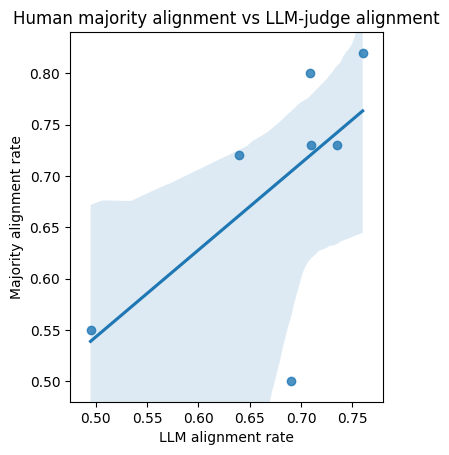

In [203]:

import seaborn as sns
gap = 0.02
sns.regplot(
    data=df_regplot,
    x='LLM alignment rate',
    y='Majority alignment rate',
    x_ci='ci',
    ci=95,
    truncate=True,
).set(
    title='Human majority alignment vs LLM-judge alignment',
    aspect='equal',
    xlim=(df_regplot['LLM alignment rate'].min() - gap, df_regplot['LLM alignment rate'].max() + gap),
    ylim=(df_regplot['Majority alignment rate'].min() - gap, df_regplot['Majority alignment rate'].max() + gap)
)


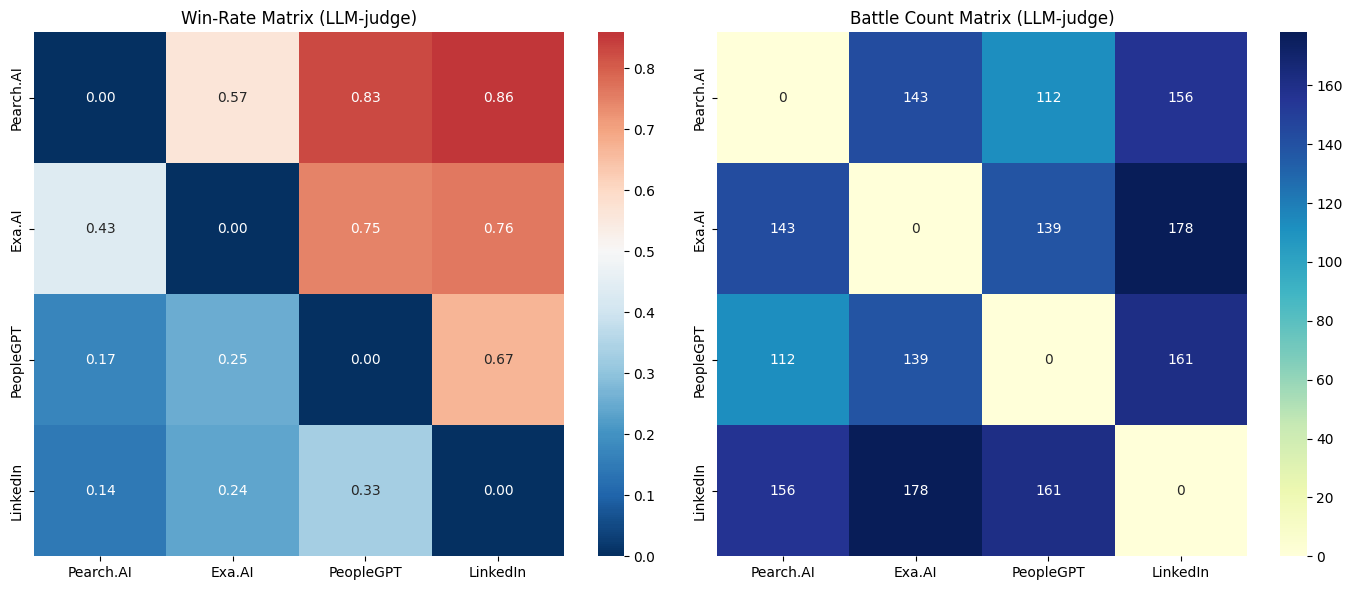

In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_win_rate_and_battle_count_heatmaps(df, winner_col='LLM winner', source1_col='source1', source2_col='source2', title_suffix=''):
    # Get all unique sources from both columns
    sources = list(set(df[source1_col]).union(set(df[source2_col])))
    
    # Initialize the win-rate matrix and battle-count matrix
    win_rate = pd.DataFrame(index=sources, columns=sources, dtype=float)
    battle_count = pd.DataFrame(index=sources, columns=sources, dtype=float)
    
    # Compute win-rate and battle count for each pair of sources
    for i in sources:
        for j in sources:
            if i == j:
                win_rate.loc[i, j] = 0.0  # Baseline for identical sources
                battle_count.loc[i, j] = 0
            else:
                # Select matches between source i and source j (order independent)
                mask = (((df[source1_col] == i) & (df[source2_col] == j)) |
                        ((df[source1_col] == j) & (df[source2_col] == i)))
                matches = df[mask]
                total_matches = len(matches)
                battle_count.loc[i, j] = total_matches
                if total_matches > 0:
                    # Count wins for source i
                    wins = (((matches[source1_col] == i) & (matches[winner_col] == i)) |
                            ((matches[source2_col] == i) & (matches[winner_col] == i))).sum()
                    wr = wins / total_matches
                    win_rate.loc[i, j] = wr
                else:
                    win_rate.loc[i, j] = np.nan
    
    # Order rows and columns by the average win-rate (ignoring NaN)
    order = win_rate.mean(axis=1).sort_values(ascending=False).index
    win_rate = win_rate.loc[order, order]
    battle_count = battle_count.loc[order, order]
    
    # Create subplots: left for win-rate matrix and right for battle count matrix
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot win-rate heatmap
    sns.heatmap(win_rate, annot=True, fmt=".2f", cmap="RdBu_r", center=0.5, cbar=True, ax=axes[0])
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    axes[0].set_title(f'Win-Rate Matrix{title_suffix}')
    
    # Plot battle-count heatmap with fmt adjusted to handle float values without decimals
    sns.heatmap(battle_count, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True, ax=axes[1])
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].set_title(f'Battle Count Matrix{title_suffix}')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_win_rate_and_battle_count_heatmaps(df_human.query('not is_test'), title_suffix=' (LLM-judge)')


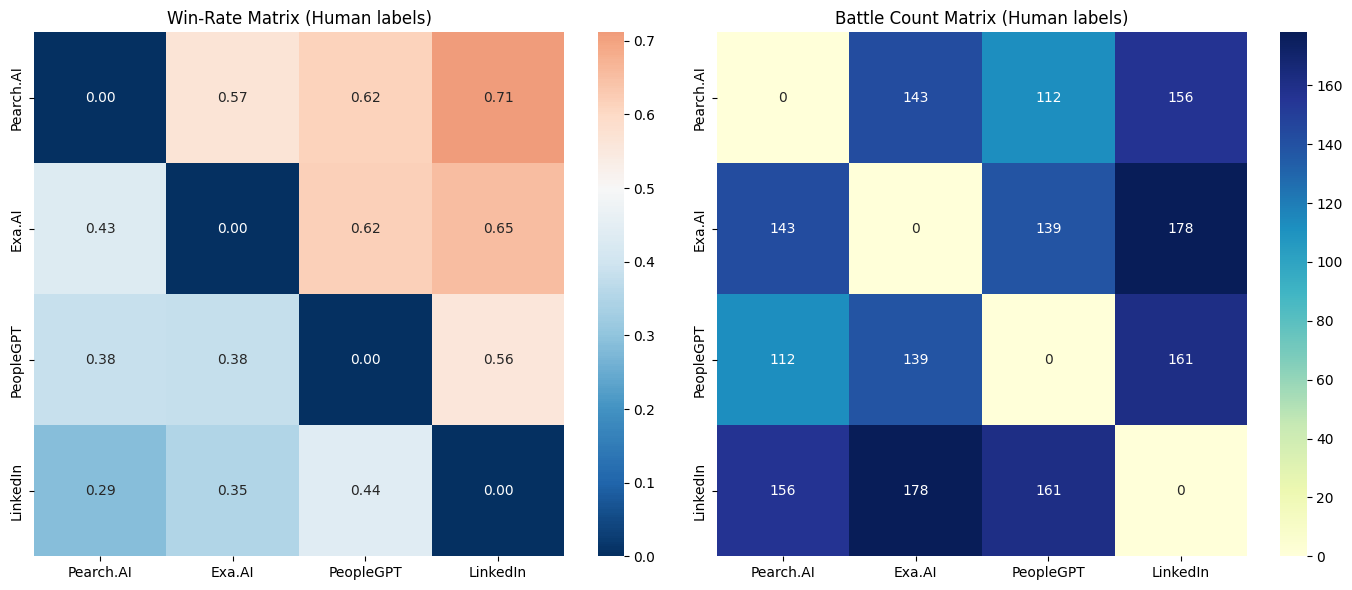

In [189]:
plot_win_rate_and_battle_count_heatmaps(df_human.query('not is_test'), winner_col='Human winner', title_suffix=' (Human labels)')


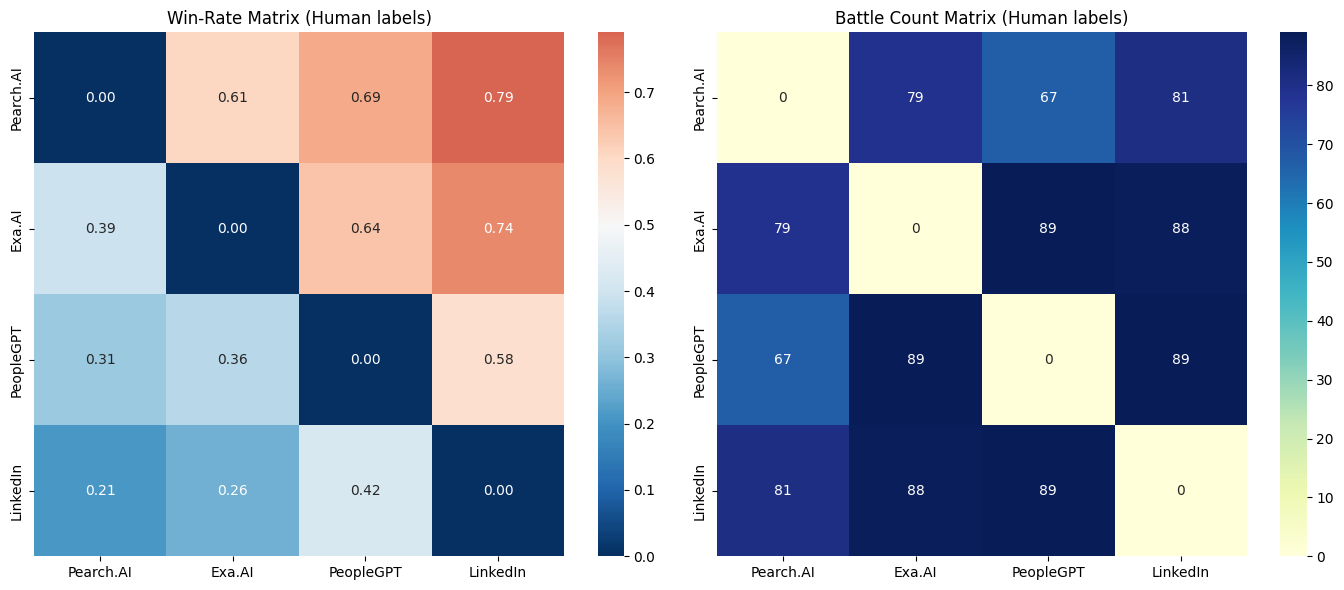

In [190]:
plot_win_rate_and_battle_count_heatmaps(df_human.query('not is_test and worker in @TOP_HUMANS'), winner_col='Human winner', title_suffix=' (Human labels)')


Elo samples:   0%|          | 0/30 [00:00<?, ?it/s]

Elo samples: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


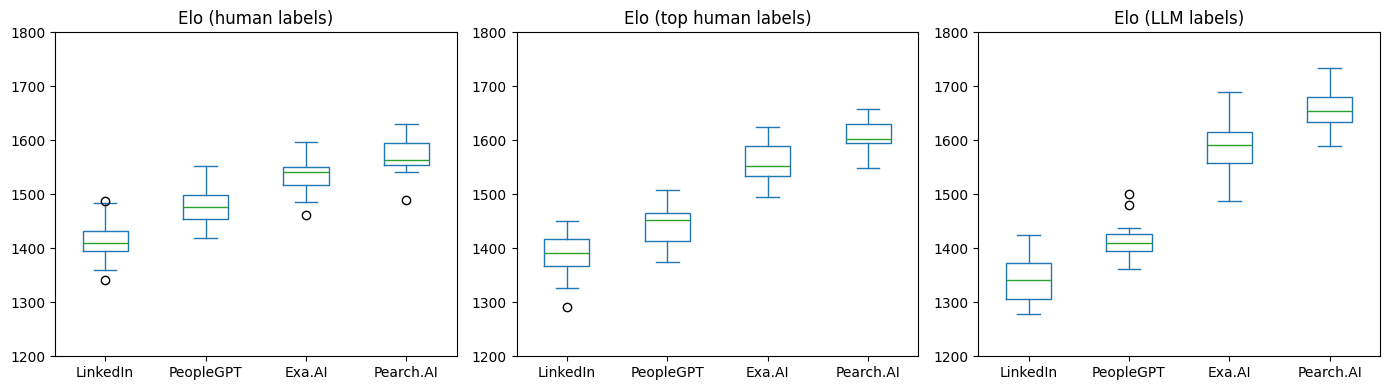

In [193]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

smpls = 30
ylim = (1200, 1800)
sbs_elo(
    df_human.query('not is_test'),
    bootstrap=False,
    n_samples=smpls,
    winner_col='Human winner'
).plot.box(ylim=ylim, title='Elo (human labels)', ax=axes[0])

sbs_elo(
    df_top_human.query('not is_test'),
    bootstrap=False,
    n_samples=smpls,
    winner_col='Human winner'
).plot.box(ylim=ylim, title='Elo (top human labels)', ax=axes[1])

sbs_elo(
    df_human.query('not is_test'),
    bootstrap=False,
    n_samples=smpls,
    winner_col='LLM winner'
).plot.box(ylim=ylim, title='Elo (LLM labels)', ax=axes[2])

plt.tight_layout()
plt.show()
